## Detecting Adverse Drug Reactions Using LLMs

This notebook provides a comprehensive guide for detecting adverse drug reactions (ADRs) using large language models (LLMs) with BERT. We tried 5 different BERT models:

* Bio-Bert
* Bio-Clinical-Bert
* Clinical-Bert
* DistilBERT
* Bert-Large-Uncased

Through testing each of these with various preprocessing steps (including Optuna optimization and back translation with Russian, Chinese, and Finnish), we found that `bert-large-uncased` with no additional preprocessing steps secured the best accuracy (Kaggle score = **.90735**). 

In terms of structure for this notebook, we start with setting up our environemnt and data processing. The latter includes data tokenization using a pre-trained BERT tokenizer to prepare the text for model input. Once we use that same BERT model for sequence classification with our two labels (severe and non-severe reactions), we define the training arguments, set up the Trainer class, and execute the training process with gradient accumulation for performance optimization. From there, we evaluate the model for accuracy!

Additionally, further down in the notebook are several visualization techniques, including: word clouds for severe and non-severe cases; a confusion matrix; and a ROC curve in the colors of VitalsCheck. 

Enjoy!

## Process the Data:

#### NOTE: When label is equal to 1, the reaction is severe. When it is 0, the reaction is not severe.

You only need to run the following cell one time!

In [1]:
# !pip install --user shap torch datasets transformers evaluate datasets

In [3]:
# Import packages:

import os
import pandas as pd
import numpy as np

In [4]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files={"train": "train_DrugExp.csv",
                                          "test": "test_DrugExp.csv",
                                          "kaggle": "val_DrugExp.csv"})

## BERT Model

#### Hardware Setup

In [4]:
! hostname

jupyter-kac5hp


In [5]:
! nvidia-smi

Wed May 14 20:12:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   29C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# !pip install transformers

In [7]:
import torch
torch.cuda.empty_cache()
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
dataset['train'][0]

{'text': 'crohns, severe in duodenum feet and ankles hurt so bad no matter laying or standing tired all the time chest feels like pressure depressed hands wrists and fingers ache foggy was on remicaid and had a bad reaction could not move for a month crohns is getting better but is the tradeoff even worth it nan',
 'label': 1}

#### Import the Tokenizer & Tokenize

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1360 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset['train'][0]

{'text': 'crohns, severe in duodenum feet and ankles hurt so bad no matter laying or standing tired all the time chest feels like pressure depressed hands wrists and fingers ache foggy was on remicaid and had a bad reaction could not move for a month crohns is getting better but is the tradeoff even worth it nan',
 'label': 1,
 'input_ids': [101,
  13675,
  11631,
  3619,
  1010,
  5729,
  1999,
  6829,
  4181,
  2819,
  2519,
  1998,
  15392,
  3480,
  2061,
  2919,
  2053,
  3043,
  10201,
  2030,
  3061,
  5458,
  2035,
  1996,
  2051,
  3108,
  5683,
  2066,
  3778,
  14777,
  2398,
  12150,
  1998,
  3093,
  12336,
  9666,
  6292,
  2001,
  2006,
  2128,
  7712,
  14326,
  1998,
  2018,
  1037,
  2919,
  4668,
  2071,
  2025,
  2693,
  2005,
  1037,
  3204,
  13675,
  11631,
  3619,
  2003,
  2893,
  2488,
  2021,
  2003,
  1996,
  3119,
  7245,
  2130,
  4276,
  2009,
  16660,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

#### Import the Pre-trained Model

In [11]:
from transformers import AutoModelForSequenceClassification

# The cased model is case-sensitive: english is not the same as English
model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)

2025-05-14 20:12:13.446601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 20:12:13.463562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747253533.484446     262 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747253533.490758     262 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747253533.506596     262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Setup the Evaluator

In [12]:
import evaluate
from scipy.special import softmax

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### Define the Training Arguments

Full docs to TrainingArguments: https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.TrainingArguments.learning_rate

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                                 output_dir="test_trainer",
    save_strategy="no",
                                 eval_strategy="epoch",
                                 per_device_train_batch_size = 8, # Increase it to speed up the training. But may ROM CUDA.
                                 per_device_eval_batch_size = 8,
                                 learning_rate = 2e-5,
                                 gradient_accumulation_steps = 8, # Backprop happens once for each 8 batches.
                                 report_to="none")

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
#     save_strategy="no" # Don't save the checkpoints
)

#### Train

In [15]:
%%time
trainer.train() # Will automatically use multiple GPUs if available.

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.290150,0.882933
2,No log,0.272671,0.901417


CPU times: user 1h 13min 35s, sys: 17min 2s, total: 1h 30min 38s
Wall time: 1h 30min 39s


TrainOutput(global_step=306, training_loss=0.2708548502205244, metrics={'train_runtime': 5439.1802, 'train_samples_per_second': 3.602, 'train_steps_per_second': 0.056, 'total_flos': 1.813538433036288e+16, 'train_loss': 0.2708548502205244, 'epoch': 2.9791921664626684})

In [16]:
import shutil
shutil.rmtree('test_trainer')

**A few notes:**
    
* Instantaneous batch size per device: the number of samples in each batch
* Gradient accumulation steps: Gradient accumulation means running a configured number of steps without updating the model variables while accumulating the gradients of those steps and then using the accumulated gradients to compute the variable updates. Using this method allows us to use larger batch sizes. It does not necessarily result in better performance, but it helps with training the models faster or on smaller devices. Read more about this in https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa.
* World_size is the number of GPU/TPUs
* The total train batch size is defined as train_batch_size * gradient_accumulation_steps * world_size, so in our case 8 * 8 * 4 = 256.

#### Save

In [17]:
YourTeamFolder = "Team 7" # Please replace this with your team folder's name (e.g., team1)

os.chdir('/home/jovyan/Data Analytics III/'+YourTeamFolder)

trainer.save_model("best_model") 

#### Load the Model

In [18]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

loaded_model = AutoModelForSequenceClassification.from_pretrained("best_model",
                                                                  local_files_only=True)
loaded_trainer = Trainer(loaded_model)

#### Predict on Kaggle Data

In [19]:
pred_logits = loaded_trainer.predict(tokenized_dataset['kaggle'])

In [20]:
pred_logits

PredictionOutput(predictions=array([[-2.9022717 ,  2.27711   ],
       [-0.97246647,  0.3484823 ],
       [ 1.4253746 , -0.8532388 ],
       ...,
       [-0.23933317,  0.42611393],
       [ 3.4925258 , -1.4825555 ],
       [ 3.3738937 , -1.6781808 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 1.957971215248108, 'test_model_preparation_time': 0.0054, 'test_runtime': 117.5824, 'test_samples_per_second': 11.566, 'test_steps_per_second': 1.446})

In [21]:
np.argmax(pred_logits[0], axis=-1)

array([1, 1, 0, ..., 1, 0, 0])

In [22]:
kaggle = pd.read_csv("val_DrugExp.csv")
kaggle['label'] = np.argmax(pred_logits[0], axis=-1)
kaggle['text'] = kaggle.text
kaggle[['text','label']].to_csv("to_kaggle.csv", index = False)

**Kaggle Score = 0.90735**

Submit your kaggle csv file through the link on Canvas.

#### Push to Hugging Face

In [15]:
from huggingface_hub import login, create_repo
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

my_token = "hf_ .... " # Put your HF token here.

login(my_token)
# create_repo(repo_id="paragon-analytics/ADRv2024") # Run this only for the first time you are pushing your model

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer.push_to_hub(repo_id = "paragon-analytics/ADRv2024",
                      use_temp_dir=True)
team_folder = "team1" # Please change!
model_path = '/project/mousavi_lab/msba24/'+team_folder+'/base_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.push_to_hub(repo_id = "paragon-analytics/ADRv2024",
                      use_temp_dir=True)

## To Use the Model in Future:

Now you can restart your kernel and try the following:

In [22]:
import torch
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased")

def adr_predict(x):
    encoded_input = tokenizer(x, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = tf.nn.softmax(scores)
    return scores.numpy()[1]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
sentence = "I have severe pain."

adr_predict(sentence)

2025-04-14 23:04:27.203664: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


0.99369335

In [5]:
sentence = "I have minor pain."

adr_predict(sentence)

0.0111666545

In [6]:
# model.parameters

## Explainable NLP

#### SHAP

In [23]:
import pandas as pd
kaggle = pd.read_csv("val_DrugExp.csv")
kaggle.iloc[0].text

"Osteopenia Took the pill, 12 hours later my muscles started to really hurt, then my ribs started to burn so bad I couldn't breath, had severe muscle spasms almost like convulsions my body was so twisted with the spasms, chills that no amount of blankets could warm, every bone, every muscle hurt, I couldn't walk I needed help getting to the bathroom, I ended up going to the hospital, after telling them what I took, they put me on high dose of steroids for the inflammation of the muscles, benadryl and pepcid for two weeks to counter act the medication. I still have extreme muscle pain in my shoulder, I have two weeks left until my month is up and I cannot wait. I will never take that poison again. I just hope that I do make a full recovery from that one pill, that is no larger than a pez! What a nighmare! Will not take again"

In [25]:
import shap, transformers
# from transformers import BertTokenizer

tokenizer = transformers.AutoTokenizer.from_pretrained("bert-large-uncased", use_fast=True)
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model,
                             tokenizer=tokenizer, device=0, return_all_scores=True) # don't change device if running on an environment with GPUs
explainer = shap.Explainer(pred)

shap_values = explainer(["Spotting, dryness during intercourse, reduced sexual drive, but no mood swings like with other birth control methods. Overall positive experience despite side effects."], fixed_context=1)
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

Device set to use cuda:0
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Visualizations

* Word Clouds
* Confusion Matrix
* ROC Curve

#### WordClouds

In [5]:
df = pd.read_csv("test_DrugExp.csv")
df.head()

,text,label
0,Osteoporosis Dysphagia (inability to swallow)....,1
1,studying bit of insomnia anxiousness i love th...,0
2,experimenting very alert lots of talking baggy...,0
3,college upset stomach extream focus difficulty...,0
4,"Dizziness Tired, seemed like I count stay awak...",1


In [6]:
# !pip install --user wordcloud

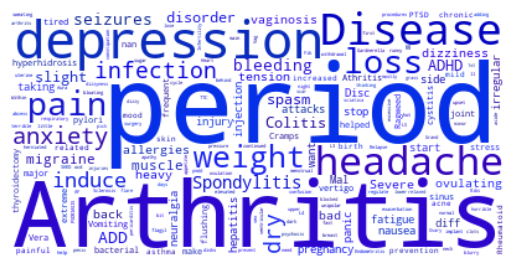

In [32]:
# Mild ADRs:

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import random

# Custom color function
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"rgb({random.randint(0, 50)}, {random.randint(0, 50)}, {random.randint(150, 255)})"

# Filter the dataframe for severe ADRs
temp = df.query('label<0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Create Stopword List
stopwords = set(STOPWORDS)
stopwords.update(["control", "none"])

# Generate the word cloud
word_cloud = WordCloud(collocations=False, background_color='white', color_func=blue_color_func, stopwords=stopwords).generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

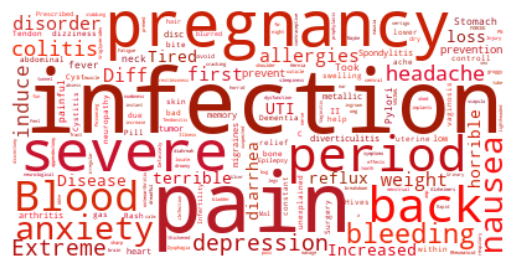

In [33]:
# Severe ADRs:

# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import random

# Custom color function for shades of red
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"rgb({random.randint(150, 255)}, {random.randint(0, 50)}, {random.randint(0, 50)})"

# Create Stopword List
stopwords = set(STOPWORDS)
stopwords.update(["control", "none"])

# Filter the dataframe for severe ADRs
temp = df.query('label>0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Generate the word cloud
word_cloud = WordCloud(collocations=False, background_color='white', color_func=red_color_func, stopwords=stopwords).generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Confusion Matrix

In [15]:
# Import packages:

import os
import pandas as pd
import numpy as np

YourTeamFolder = "Team 7"
os.chdir('/home/jovyan/Data Analytics III/'+YourTeamFolder)

In [16]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files={"train": "train_DrugExp.csv",
                                          "test": "test_DrugExp.csv",
                                          "kaggle": "val_DrugExp.csv"})

In [17]:
import torch
torch.cuda.empty_cache()
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased") # Be sure to use the same tokenizer

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [19]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

loaded_model = AutoModelForSequenceClassification.from_pretrained("best_model",
                                                                  local_files_only=True)
loaded_trainer = Trainer(loaded_model)

2025-05-14 02:59:27.222498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 02:59:27.234211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747191567.248581     102 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747191567.252859     102 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747191567.263533     102 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [20]:
pred_logits = loaded_trainer.predict(tokenized_dataset['test'])

In [22]:
test = pd.read_csv("test_DrugExp.csv")
test['predicted_label'] = np.argmax(pred_logits[0], axis=-1)
test.head()

,text,label,predicted_label
0,Osteoporosis Dysphagia (inability to swallow)....,1,1
1,studying bit of insomnia anxiousness i love th...,0,0
2,experimenting very alert lots of talking baggy...,0,0
3,college upset stomach extream focus difficulty...,0,0
4,"Dizziness Tired, seemed like I count stay awak...",1,1


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

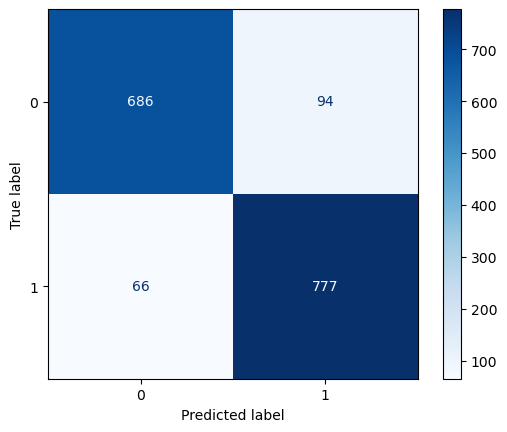

In [42]:
cm = confusion_matrix(test.label, test.predicted_label, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()

In [43]:
accuracy_score(test.label, test.predicted_label)

0.9014171287738756

#### ROC Curve

In [13]:
!pip install --user spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.1 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.2.3 requires scikit-plot, which is not installed.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
explainerdashboard 0.4.8 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.0 which is incompatible.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.

In [14]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import spacy
from spacy import displacy

text = df.text.iloc[0]
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.render(doc, style="ent")

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu
pipe("""The patient reported no recurrence of palpitations at follow-up 6 months after the ablation.""")

Device set to use cpu


[{'entity_group': 'Sign_symptom',
  'score': 0.9999311,
  'word': 'pal',
  'start': 38,
  'end': 41},
 {'entity_group': 'Sign_symptom',
  'score': 0.90633154,
  'word': '##pitations',
  'start': 41,
  'end': 50},
 {'entity_group': 'Clinical_event',
  'score': 0.99975544,
  'word': 'follow',
  'start': 54,
  'end': 60},
 {'entity_group': 'Date',
  'score': 0.999867,
  'word': '6 months after',
  'start': 64,
  'end': 78}]

In [20]:
# import tensorflow as tf

In [44]:
pred_logits[0]

array([[-2.3567944,  2.7400353],
       [ 1.0279933, -0.841978 ],
       [ 2.1533391, -1.9106288],
       ...,
       [ 0.8176423, -0.8711464],
       [ 2.4535327, -2.2913034],
       [ 2.320769 , -2.4041524]], dtype=float32)

In [45]:
prediction = tf.nn.sigmoid(np.array(pred_logits[0]))

In [46]:
test['predicted_prob1'] = prediction[:,1]

In [47]:
test.head()

,text,label,predicted_label,predicted_prob1
0,Osteoporosis Dysphagia (inability to swallow)....,1,1,0.939348
1,studying bit of insomnia anxiousness i love th...,0,0,0.301118
2,experimenting very alert lots of talking baggy...,0,0,0.128910
3,college upset stomach extream focus difficulty...,0,0,0.086230
4,"Dizziness Tired, seemed like I count stay awak...",1,1,0.857905


In [52]:
# Importing function that can be used to calculate different metrics such as accuracy, precision, recall.
from sklearn.metrics import * 

def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    accuracy = accuracy_score(actualLabels, predictions) * 100
    precisionNegative = precision_score(actualLabels, predictions, average = None)[0] * 100
    precisionPositive = precision_score(actualLabels, predictions, average = None)[1] * 100
    recallNegative = recall_score(actualLabels, predictions, average = None)[0] * 100
    recallPositive = recall_score(actualLabels, predictions, average = None)[1] * 100
    auc = roc_auc_score(actualLabels, predictionsProbabilities) * 100
    
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))

AUC Score = 0.963


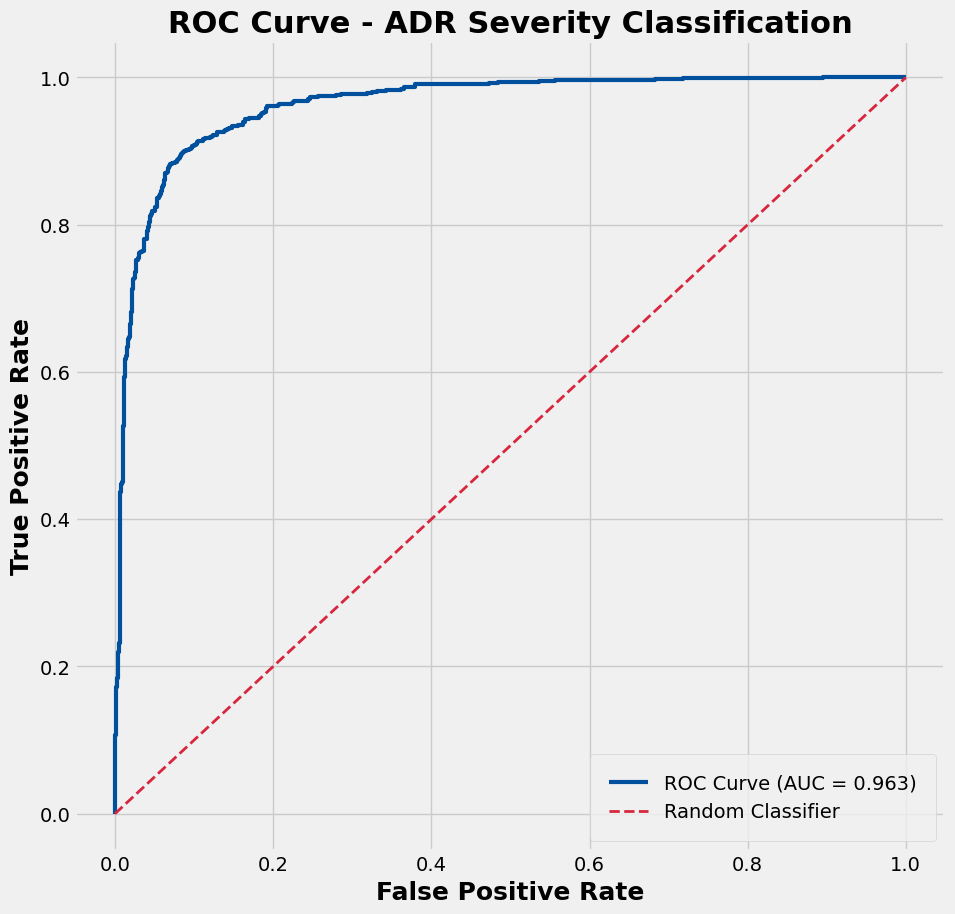

In [53]:
def custom_plot_roc_curve(fpr, tpr, auc_score):
    # Set the FiveThirtyEight style
    plt.style.use('fivethirtyeight')
    
    # Plot the ROC curve (blue line)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='#00509E', linewidth=3, label=f'ROC Curve (AUC = {auc_score:.3f})')
    
    # Plot the diagonal reference line (red dashed line)
    plt.plot([0, 1], [0, 1], color='#D7263D', linestyle='--', linewidth=2, label='Random Classifier')
    
    # Add labels and title
    plt.xlabel('False Positive Rate', fontsize=18, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=18, fontweight='bold')
    plt.title('ROC Curve - ADR Severity Classification', fontsize=22, fontweight='bold')
    plt.legend(loc="lower right", fontsize=14, frameon=True, fancybox=True, framealpha=0.8, borderpad=1)
    plt.show()

# Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(test.label, test['predicted_prob1'], pos_label=1)
lr_auc = roc_auc_score(test.label, test['predicted_prob1'])
print(f'AUC Score = {lr_auc:.3f}')

# Plot the ROC curve
custom_plot_roc_curve(fpr, tpr, lr_auc)